In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
# Read in the data
# set engine parameter to "openpyxl"
df = pd.read_excel(open('model data.xlsx', 'rb'), sheet_name='data', engine = 'openpyxl')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True) # set column to index
numberOfHours = len(df.index)
df.dtypes

Demand (MW)               int64
real time price         float64
day ahead price         float64
AC System Output (W)    float64
Hashrate (TH/s)           int64
Total Miner Revenue     float64
dtype: object

In [3]:
df_inputs = pd.read_excel(open('model data.xlsx', 'rb'), sheet_name='inputs', engine = 'openpyxl')
df_inputs.dtypes

Key inputs    object
Value         object
Notes         object
dtype: object

In [4]:
# Hourly electric grid demand
demandScaleFactor = df_inputs[df_inputs['Key inputs']=='Grid scale down factor'].Value.item()
gridLoad = demandScaleFactor * df['Demand (MW)'].to_numpy()
# Demand above which other sources step in 
B = df_inputs[df_inputs['Key inputs']=='Demand above which other sources step in (MW)'].Value.item()
b = df_inputs[df_inputs['Key inputs']=='Baseload power (MW)'].Value.item() # Baseload supply
# Electricity demand system seeking to fill above input baseload and below some specified ancillary services
sbbSystemDemand = np.minimum(np.maximum(gridLoad - b, 0), B - b) # (col D)

In [5]:
# Day ahead pricing max realized price electricity
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=24)
#indexer = pd.api.indexers.VariableOffsetWindowIndexer('1D')
df['Max day ahead price ($/MWh)'] = df['day ahead price'].rolling(window=indexer, min_periods=1).max() # (col J)
# Current miner realizable revenue net of variable costs
minerPowerUsage = 1e-3 * df_inputs[df_inputs['Key inputs']=='Power usage (kW)'].Value.item()
minerEfficiency = df_inputs[df_inputs['Key inputs']=='Hardware efficiency'].Value.item()
minerMaxHashrate = df_inputs[df_inputs['Key inputs']=='Max hashrate (TH/s)'].Value.item()
variableCost = 1e3 * df_inputs[df_inputs['Key inputs']=='Variable cost ($/kWh)'].Value.item()
hashratePerPower = minerMaxHashrate * minerEfficiency / minerPowerUsage # TH/s / kW
df['Miner Realizable Price ($/MWh)'] = hashratePerPower * df['Total Miner Revenue'] / df['Hashrate (TH/s)'] - variableCost # (col K)

<AxesSubplot:xlabel='Timestamp'>

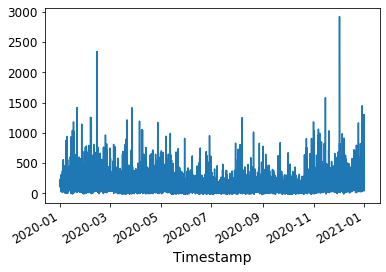

In [6]:
df['Miner Realizable Price ($/MWh)'].plot() # Miner realizable price (col K)

In [7]:
# Miner dispatch decision made on [input] trailing average hash/revenue information
offsetWindow = df_inputs[df_inputs['Key inputs']=='Miner lookback offset for dispatch decision'].Value.item()
df['Trailing Avg Miner Realizable Price ($/MWh)'] = df['Miner Realizable Price ($/MWh)'].rolling(offsetWindow).mean() # Trailing average miner realizable price (col L)
# Move towards this battery fill-level given current realizable revenue in crypto vs electricity sales
targetFrac = df_inputs[df_inputs['Key inputs']=='Target battery fill before shift to miner'].Value.item() # Breakeven battery fill percent
x = np.linspace(0, 1, num=101)
a = 12 * (x - targetFrac)
y = (2 / (1 + np.exp(-a)))**2
batteryDispatchY = (df['Max day ahead price ($/MWh)'] / df['Trailing Avg Miner Realizable Price ($/MWh)']).to_numpy()
miningAdjusterThreshold = 1.8
Y = np.where(batteryDispatchY < miningAdjusterThreshold, batteryDispatchY, miningAdjusterThreshold)
batteryDispatchX = targetFrac - np.log(2 / np.sqrt(Y) - 1) / 12
batteryDispatchX = np.minimum(batteryDispatchX, 1.0) # Breakeven battery fill percent (col N)

[(-0.05, 1.05),
 Text(0.5, 0, 'battery charge state'),
 Text(0, 0.5, 'mining adjuster')]

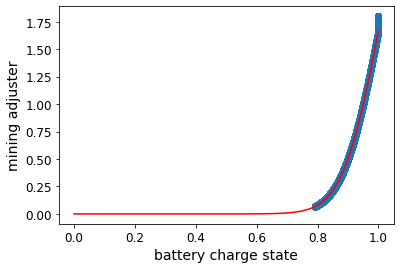

In [8]:
fig, ax = plt.subplots()
ax.plot(x,y,'r-') # Plot the battery dispatch curve
ax.scatter(batteryDispatchX, Y)
ax.set(xlim=[-0.05, 1.05], xlabel='battery charge state', ylabel='mining adjuster')

[(0.0, 8760.0),
 (0.0, 1.2),
 Text(0.5, 0, 'time (h)'),
 Text(0, 0.5, 'battery charge state')]

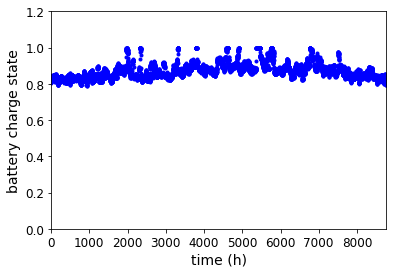

In [9]:
fig, ax = plt.subplots()
ax.plot(batteryDispatchX,'b.') # Battery dispatch curve
ax.set(xlim=[0, numberOfHours], ylim=[0, 1.2], xlabel='time (h)', ylabel='battery charge state')

In [10]:
# netFillToBattery =
    # + With battery and grid in supply state, surplus energy to battery after mining (col AC)
    # + With battery in demand state, remaining possible excess power devoted to battery (col W)
    # + With battery in demand state, fill to battery (col S)
    # - With battery and grid in supply state, additional battery energy to mining after surplus energy dispatch (col AD)
    # - With battery in supply state and grid in demand, energy used from battery by miner (col Z)
    # - Battery drawdown to meet electricity dispatch (col F)

hoursPerYear = 24 * 365
batterySizesStr = df_inputs[df_inputs['Key inputs']=='Battery system size (MWh)'].Value.item()
batterySizes = np.fromiter(map(int, batterySizesStr.split(';')), dtype=np.int)
batteryRelativePower = df_inputs[df_inputs['Key inputs']=='Battery power size ratio (1/h)'].Value.item()
batteryStartingFill = df_inputs[df_inputs['Key inputs']=='Battery starting fill'].Value.item()
miningSystemSizesStr = df_inputs[df_inputs['Key inputs']=='Mining system size (MW)'].Value.item()
miningSystemSizes = np.fromiter(map(int, miningSystemSizesStr.split(';')), dtype=np.int)
solarSystemSizesStr = df_inputs[df_inputs['Key inputs']=='Solar system size (MW)'].Value.item()
solarSystemSizes = np.fromiter(map(int, solarSystemSizesStr.split(';')), dtype=np.int)
solarLifespanHours = hoursPerYear * df_inputs[df_inputs['Key inputs']=='Lifespan (years)'].Value.item()
solarCapCost = 1e6 * df_inputs[df_inputs['Key inputs']=='Solar capital cost ($/W)'].Value.item()
batteryCapCost = 1e3 * df_inputs[df_inputs['Key inputs']=='Battery capital cost ($/kWh)'].Value.item()
minerCapCost = df_inputs[df_inputs['Key inputs']=='Rig cost ($)'].Value.item() / minerPowerUsage
minerLifespanHours = hoursPerYear * df_inputs[df_inputs['Key inputs']=='Miner lifespan (years)'].Value.item()
solarFixedOandMCost = 1e3 * df_inputs[df_inputs['Key inputs']=='Solar Fixed O&M cost ($/kW-yr)'].Value.item() / hoursPerYear
batteryFixedOandMCost = 1e3 * df_inputs[df_inputs['Key inputs']=='Battery O&M cost ($/kWh)'].Value.item() / hoursPerYear

In [11]:
# Battery energy in storage (MWh)
electricitySuppliedDemandedRatioList = []
ratioHoursSystemMeetsGridDemandList = []
for solarSystemSize, batterySize, miningSystemSize in zip(solarSystemSizes, batterySizes, miningSystemSizes):
    # Solar generation
    solarGeneration = 1e-6 * solarSystemSize * df['AC System Output (W)'].to_numpy() # (col E)
    batteryPower = batteryRelativePower * batterySize
    currentBatteryEnergyInStorage = batteryStartingFill * batterySize
    netFillToBattery = 0
    batteryEnergyInStorage = np.zeros(numberOfHours) # Initialize (col Q)
    batteryDrawdown = np.zeros(numberOfHours) # Initialize (col F)
    minerPowerDraw = np.zeros(numberOfHours) # Initialze (col AJ)
    #unusedWastedPower = np.zeros(numberOfHours) # Initialize (col AG)
    for n in range(numberOfHours):    
        batteryEnergyInStorage[n] = currentBatteryEnergyInStorage # Battery energy in storage (col Q)
        # Amount of electricity generated by solar in excess of demand
        surplusForBatteryOrMining = max(solarGeneration[n] - sbbSystemDemand[n], 0) # Surplus for battery/mining (col I)
        if sbbSystemDemand[n] > solarGeneration[n]: # Battery drawdown to meet electricity dispatch (col F)
            batteryDrawdown[n] = min(sbbSystemDemand[n] - solarGeneration[n], batteryPower, batteryEnergyInStorage[n])
        
        desiredDrawFromBattery = batteryDispatchX[n] * batterySize - batteryEnergyInStorage[n] - batteryDrawdown[n] # Desired fill to/draw from battery (col R)
        # With battery in demand state, fill to battery (col S) and excess power not dispatched to battery (col T)
        if desiredDrawFromBattery > 0:
            demandStateFillToBattery = min(desiredDrawFromBattery, batteryPower, surplusForBatteryOrMining)
            excessPowerNotDispatchedToBattery = surplusForBatteryOrMining - demandStateFillToBattery
        else:
            demandStateFillToBattery = 0
            excessPowerNotDispatchedToBattery = 0

        excessPowerToMiner = min(miningSystemSize, excessPowerNotDispatchedToBattery) # With battery in demand state, devote excess power to miner (col U)
        incrementalExcessPowerAvailable = excessPowerNotDispatchedToBattery - excessPowerToMiner # With battery in demand state, incremental excess power available (col V)
        # With battery in supply state and grid in demand, additional energy available for miner (col Y)
        if batteryDrawdown[n] > 0 and desiredDrawFromBattery < 0: # Grid is in a demand state = batteryDrawdown > 0
            additionalAvailableMinerEnergy = min(-desiredDrawFromBattery, batteryPower - batteryDrawdown[n])
        else:
            additionalAvailableMinerEnergy = 0

        energyFromBatteryToMiner = min(additionalAvailableMinerEnergy, miningSystemSize) # With battery in supply state and grid in demand, energy used from battery by miner (col Z)
        excessPowerToBattery = min(incrementalExcessPowerAvailable + demandStateFillToBattery, batteryPower, batterySize - batteryEnergyInStorage[n]) - demandStateFillToBattery # With battery in demand state, remaining possible excess power devoted to battery (col W)
        excessPowerUnused = incrementalExcessPowerAvailable - excessPowerToBattery # With battery in demand state, excess power unused (col X)
        if batteryDrawdown[n] > 0 or desiredDrawFromBattery > 0:
            supplyEnergyGeneratedToMiner = 0 # With battery and grid in surplus state, supply energy generated to miner (col AA)
            addSurplusEnergyAvailableForBattery = 0 # With battery and grid in supply state, additional surplus energy available for battery (col AB)
            addBatteryEnergyToMiningAfterSurplusEnergyDispatch = 0 # With battery and grid in supply state, additional battery energy to mining after surplus energy dispatch (col AD)
        else:
            supplyEnergyGeneratedToMiner = min(surplusForBatteryOrMining, miningSystemSize)
            addSurplusEnergyAvailableForBattery = surplusForBatteryOrMining - supplyEnergyGeneratedToMiner
            addBatteryEnergyToMiningAfterSurplusEnergyDispatch = min(miningSystemSize - supplyEnergyGeneratedToMiner, batteryPower)

        surplusEnergyToBatteryAfterMining = min(addSurplusEnergyAvailableForBattery, batteryPower, batterySize - batteryEnergyInStorage[n]) # With battery and grid in supply state, surplus energy to battery after mining (col AC)
        unusedEnergy = addSurplusEnergyAvailableForBattery - surplusEnergyToBatteryAfterMining # With battery and grid in supply state, unused energy (col AE)
        #unusedWastedPower[n] = excessPowerUnused + unusedEnergy # Unused/wasted power (col AG)
        netFillToBattery = surplusEnergyToBatteryAfterMining + excessPowerToBattery + demandStateFillToBattery - addBatteryEnergyToMiningAfterSurplusEnergyDispatch - energyFromBatteryToMiner - batteryDrawdown[n] # Net fill to or draw from battery (col AF)
        currentBatteryEnergyInStorage += netFillToBattery # Update battery energy storage
        minerPowerDraw[n] = excessPowerToMiner + energyFromBatteryToMiner + supplyEnergyGeneratedToMiner + addBatteryEnergyToMiningAfterSurplusEnergyDispatch # Miner power draw (col AJ)
        
    # Total electricity supplied, Electricity sold (col G)
    electricitySold = np.minimum(sbbSystemDemand, solarGeneration + batteryDrawdown)
    # The difference between electricity supplied and the amount demanded of solar+battery,
    # Generation gap (did the system supply requested energy) (col H)
    supplyGap = electricitySold - sbbSystemDemand
    # Percent of hours the system meets grid demand
    r = 1. - float(np.count_nonzero(supplyGap < 0))/float(numberOfHours)
    electricitySuppliedDemandedRatio = np.sum(solarGeneration)/np.sum(sbbSystemDemand)
    electricitySuppliedDemandedRatioList.append(electricitySuppliedDemandedRatio)
    ratioHoursSystemMeetsGridDemandList.append(r)
    # Financial stuff
    revenueElectricPower = electricitySold * df['real time price'].to_numpy() # (col AK)
    solarDepreciation = solarSystemSize * solarCapCost / solarLifespanHours # (col AL)
    batteryDepreciation = batterySize * batteryCapCost / solarLifespanHours # (col AM)
    solarOandM = -solarFixedOandMCost * solarSystemSize # (col AN)
    batteryOandM = -batteryFixedOandMCost * batterySize # (col AO)
    # where does the battery system price levelize with day ahead pricing
    solarBatteryProfit = revenueElectricPower - solarDepreciation - batteryDepreciation + solarOandM + batteryOandM # (col AP)
    deployedHashrate = minerPowerDraw * hashratePerPower # (col AT)
    shareOfGlobalHashrate = deployedHashrate / df['Hashrate (TH/s)'].to_numpy() # (col AU)
    minerRevenue = shareOfGlobalHashrate * df['Total Miner Revenue'].to_numpy() # (col AV)
    miningVariableCost = np.where(deployedHashrate > 0, miningSystemSize * variableCost, 0) # (col AW)
    minerDepreciation = miningSystemSize * minerCapCost / minerLifespanHours # (col AX)
    minerProfit = minerRevenue - miningVariableCost - minerDepreciation # (col AY)
    totalProfit = solarBatteryProfit + minerProfit # (col AZ)
    print(f'For scenario Solar {solarSystemSize} MW, Battery {batterySize} MWh and mining {miningSystemSize} MW:')
    print(f'Electricity supplied/electricty demanded: {100*electricitySuppliedDemandedRatio:.1f}%')
    print(f'Percentage of hours system meets grid demand: {100*r:.2f}%')
    print(f'Total profit/loss: ${np.sum(totalProfit):,.0f}')
    print('--')

For scenario Solar 90 MW, Battery 210 MWh and mining 0 MW:
Electricity supplied/electricty demanded: 30.5%
Percentage of hours system meets grid demand: 10.98%
Total profit/loss: $-2,286,329
--
For scenario Solar 109 MW, Battery 265 MWh and mining 0 MW:
Electricity supplied/electricty demanded: 37.0%
Percentage of hours system meets grid demand: 19.93%
Total profit/loss: $-2,814,834
--
For scenario Solar 172 MW, Battery 300 MWh and mining 0 MW:
Electricity supplied/electricty demanded: 58.4%
Percentage of hours system meets grid demand: 40.01%
Total profit/loss: $-3,812,871
--
For scenario Solar 650 MW, Battery 280 MWh and mining 178 MW:
Electricity supplied/electricty demanded: 220.5%
Percentage of hours system meets grid demand: 49.75%
Total profit/loss: $-15,979,227
--
For scenario Solar 890 MW, Battery 425 MWh and mining 280 MW:
Electricity supplied/electricty demanded: 302.0%
Percentage of hours system meets grid demand: 60.05%
Total profit/loss: $-22,667,422
--
For scenario Solar

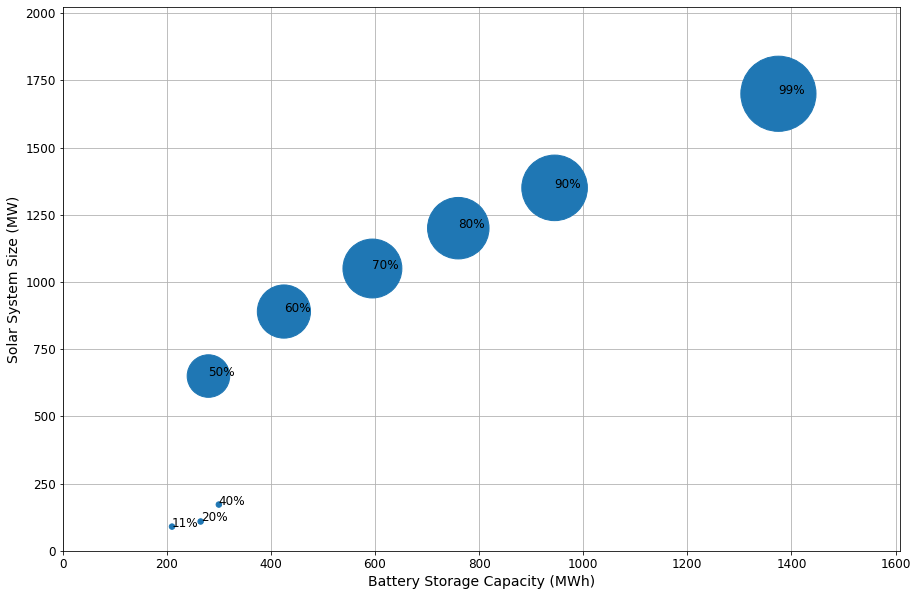

In [12]:
markerStartingSize = 3
markerSizeFactor = 10
markerAreas = markerSizeFactor * (miningSystemSizes + markerStartingSize)
fig, ax = plt.subplots(figsize=(1.5 * markerSizeFactor, markerSizeFactor))
ax.grid(True)
ax.scatter(batterySizes, solarSystemSizes, s=markerAreas) # Scatter plot
#for posX, posY, label, yOffset in zip(batterySizes, solarSystemSizes, labels, markerAreas):
#    ax.annotate(label, xy=(posX, posY), xytext=(-12, -1.4*yOffset), textcoords="offset points")
for posX, posY, labelRaw in zip(batterySizes, solarSystemSizes, ratioHoursSystemMeetsGridDemandList):
    label = str(int(round(100*labelRaw)))+'%'
    ax.annotate(label, xy=(posX, posY))

ax.set(xlabel='Battery Storage Capacity (MWh)', ylabel='Solar System Size (MW)')
ax.margins(0.2)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.grid(True)
ax.set_axisbelow(True)

[(0.0, 8760.0),
 (-1.0, 1.0),
 Text(0.5, 0, 'time (h)'),
 Text(0, 0.5, 'power sum (pW)')]

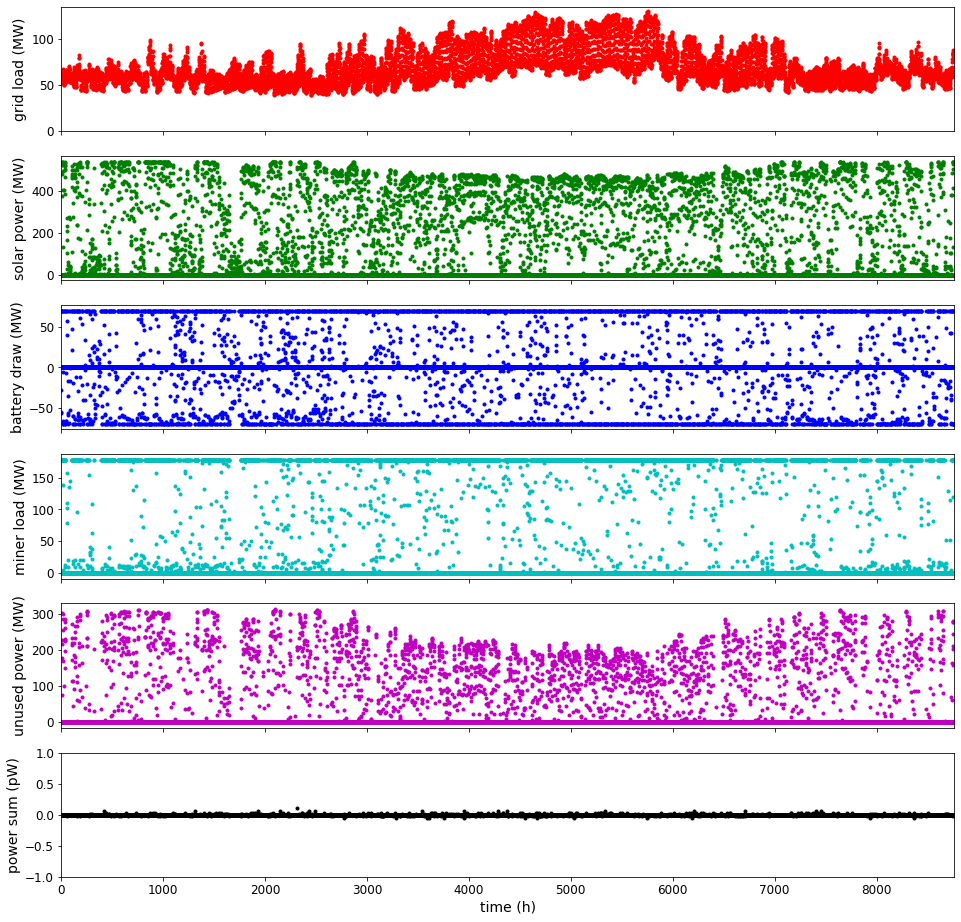

In [13]:
scenario = 3 # Plot for a specific scenario
solarSystemSize, batterySize, miningSystemSize = list(zip(solarSystemSizes, batterySizes, miningSystemSizes))[scenario]
# Solar generation
solarGeneration = 1e-6 * solarSystemSize * df['AC System Output (W)'].to_numpy() # (col E)
batteryPower = batteryRelativePower * batterySize
currentBatteryEnergyInStorage = batteryStartingFill * batterySize
netFillToBattery = np.zeros(numberOfHours) # Initialize
batteryEnergyInStorage = np.zeros(numberOfHours) # Initialize (col Q)
batteryDrawdown = np.zeros(numberOfHours) # Initialize (col F)
minerPowerDraw = np.zeros(numberOfHours) # Initialze (col AJ)
unusedWastedPower = np.zeros(numberOfHours) # Initialize (col AG)
for n in range(numberOfHours):    
    batteryEnergyInStorage[n] = currentBatteryEnergyInStorage # Battery energy in storage (col Q)
    # Amount of electricity generated by solar in excess of demand
    surplusForBatteryOrMining = max(solarGeneration[n] - sbbSystemDemand[n], 0) # Surplus for battery/mining (col I)
    if sbbSystemDemand[n] > solarGeneration[n]: # Battery drawdown to meet electricity dispatch (col F)
        batteryDrawdown[n] = min(sbbSystemDemand[n] - solarGeneration[n], batteryPower, batteryEnergyInStorage[n])
    
    desiredDrawFromBattery = batteryDispatchX[n] * batterySize - batteryEnergyInStorage[n] - batteryDrawdown[n] # Desired fill to/draw from battery (col R)
    # With battery in demand state, fill to battery (col S) and excess power not dispatched to battery (col T)
    if desiredDrawFromBattery > 0:
        demandStateFillToBattery = min(desiredDrawFromBattery, batteryPower, surplusForBatteryOrMining)
        excessPowerNotDispatchedToBattery = surplusForBatteryOrMining - demandStateFillToBattery
    else:
        demandStateFillToBattery = 0
        excessPowerNotDispatchedToBattery = 0

    excessPowerToMiner = min(miningSystemSize, excessPowerNotDispatchedToBattery) # With battery in demand state, devote excess power to miner (col U)
    incrementalExcessPowerAvailable = excessPowerNotDispatchedToBattery - excessPowerToMiner # With battery in demand state, incremental excess power available (col V)
    # With battery in supply state and grid in demand, additional energy available for miner (col Y)
    if batteryDrawdown[n] > 0 and desiredDrawFromBattery < 0: # Grid is in a demand state = batteryDrawdown > 0
        additionalAvailableMinerEnergy = min(-desiredDrawFromBattery, batteryPower - batteryDrawdown[n])
    else:
        additionalAvailableMinerEnergy = 0

    energyFromBatteryToMiner = min(additionalAvailableMinerEnergy, miningSystemSize) # With battery in supply state and grid in demand, energy used from battery by miner (col Z)
    excessPowerToBattery = min(incrementalExcessPowerAvailable + demandStateFillToBattery, batteryPower, batterySize - batteryEnergyInStorage[n]) - demandStateFillToBattery # With battery in demand state, remaining possible excess power devoted to battery (col W)
    excessPowerUnused = incrementalExcessPowerAvailable - excessPowerToBattery # With battery in demand state, excess power unused (col X)
    if batteryDrawdown[n] > 0 or desiredDrawFromBattery > 0:
        supplyEnergyGeneratedToMiner = 0 # With battery and grid in surplus state, supply energy generated to miner (col AA)
        addSurplusEnergyAvailableForBattery = 0 # With battery and grid in supply state, additional surplus energy available for battery (col AB)
        addBatteryEnergyToMiningAfterSurplusEnergyDispatch = 0 # With battery and grid in supply state, additional battery energy to mining after surplus energy dispatch (col AD)
    else:
        supplyEnergyGeneratedToMiner = min(surplusForBatteryOrMining, miningSystemSize)
        addSurplusEnergyAvailableForBattery = surplusForBatteryOrMining - supplyEnergyGeneratedToMiner
        addBatteryEnergyToMiningAfterSurplusEnergyDispatch = min(miningSystemSize - supplyEnergyGeneratedToMiner, batteryPower)

    surplusEnergyToBatteryAfterMining = min(addSurplusEnergyAvailableForBattery, batteryPower, batterySize - batteryEnergyInStorage[n]) # With battery and grid in supply state, surplus energy to battery after mining (col AC)
    unusedEnergy = addSurplusEnergyAvailableForBattery - surplusEnergyToBatteryAfterMining # With battery and grid in supply state, unused energy (col AE)
    unusedWastedPower[n] = excessPowerUnused + unusedEnergy # Unused/wasted power (col AG)
    netFillToBattery[n] = surplusEnergyToBatteryAfterMining + excessPowerToBattery + demandStateFillToBattery - addBatteryEnergyToMiningAfterSurplusEnergyDispatch - energyFromBatteryToMiner - batteryDrawdown[n] # Net fill to or draw from battery (col AF)
    currentBatteryEnergyInStorage += netFillToBattery[n] # Update battery energy storage
    minerPowerDraw[n] = excessPowerToMiner + energyFromBatteryToMiner + supplyEnergyGeneratedToMiner + addBatteryEnergyToMiningAfterSurplusEnergyDispatch # Miner power draw (col AJ)
    
# Total electricity supplied, Electricity sold (col G)
electricitySold = np.minimum(sbbSystemDemand, solarGeneration + batteryDrawdown)
# The difference between electricity supplied and the amount demanded of solar+battery,
# Generation gap (did the system supply requested energy) (col H)
supplyGap = electricitySold - sbbSystemDemand
powerSum = solarGeneration - supplyGap - netFillToBattery - gridLoad - minerPowerDraw - unusedWastedPower
powerSum *= 1e12 # convert to watts
xA = 0
xB = len(gridLoad)
#xA = 0
#xB = 72
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 6, sharex=True, figsize=(16,16))

ax0.plot(gridLoad, 'r.') # Grid load curve
ax0.set(xlim=[xA, xB], ylabel='grid load (MW)')
ax0.set_ylim(ymin=0)

ax1.plot(solarGeneration, 'g.') # Solar generation curve
ax1.set(xlim=[xA, xB], ylabel='solar power (MW)')
#ax1.set_ylim(ymin=0)

ax2.plot(netFillToBattery, 'b.') # Battery net draw curve
#ax2.set(xlim=[0, n], ylim=[-batteryPower, batteryPower], ylabel='net battery draw (MW)')
ax2.set(xlim=[xA, xB], ylabel='battery draw (MW)')

ax3.plot(minerPowerDraw, 'c.') # Miner power curve
ax3.set(xlim=[xA, xB], ylabel='miner load (MW)')

ax4.plot(unusedWastedPower, 'm.') # Battery dispatch curve
ax4.set(xlim=[xA, xB], ylabel='unused power (MW)')
#ax4.set_ylim(ymin=0)

ax5.plot(powerSum, 'k.') # Battery dispatch curve
ax5.set(xlim=[xA, xB], ylim=[-1, 1], xlabel='time (h)', ylabel='power sum (pW)')